In [1]:
!conda run pip install aiogram
!conda run pip install beautifulsoup4
!conda run pip install pymystem3
!conda run pip install wordcloud
!conda run pip install nltk
!conda run pip install jellyfish
!conda run pip install nest-asyncio
!conda run pip install emoji

Looking in indexes: https://artifactory.tdp.corp.tele2.ru/artifactory/api/pypi/bdo-pypi-all/simple

Looking in indexes: https://artifactory.tdp.corp.tele2.ru/artifactory/api/pypi/bdo-pypi-all/simple

Looking in indexes: https://artifactory.tdp.corp.tele2.ru/artifactory/api/pypi/bdo-pypi-all/simple

Looking in indexes: https://artifactory.tdp.corp.tele2.ru/artifactory/api/pypi/bdo-pypi-all/simple

Looking in indexes: https://artifactory.tdp.corp.tele2.ru/artifactory/api/pypi/bdo-pypi-all/simple

Looking in indexes: https://artifactory.tdp.corp.tele2.ru/artifactory/api/pypi/bdo-pypi-all/simple
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp39-cp39-linux_x86_64.whl size=57418 sha256=d6b31c4330b00b2f6eeba9d42e7c24a4cd857f54cfd617a1022ea1891feb9f2c
  Stored in directory: /home/appuser/.cache/pip/wheels/d4/c0/c0/61651a8784ae396b6a0022d8ee851bf020baa018163ae395a2
Successfully built

In [2]:
from aiogram import Bot, Dispatcher, types
from aiogram.dispatcher.filters import Text
from aiogram.dispatcher import FSMContext
from aiogram.dispatcher.filters.state import State, StatesGroup
from aiogram.utils import executor
from aiogram.contrib.fsm_storage.memory import MemoryStorage
from aiogram.types import ParseMode, InputMediaPhoto, InputMediaVideo, ChatActions, InputFile
import aiogram.utils.markdown as fmt

import json
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import random
import jellyfish
import re
import nltk
import nest_asyncio
import emoji
nest_asyncio.apply()
nltk.download('stopwords')

from src.logs_maker import init_logger

logger = init_logger(name=__name__)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/appuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def get_replics(url: str, chapter:str) -> pd.DataFrame:
    headers = requests.utils.default_headers()

    headers.update(
        {
            'User-Agent': 'My User Agent 1.0',
        }
    )
    r = requests.get(url, headers=headers)
    r.encoding = 'cp1251'
    soup = bs(r.text, 'html.parser')
    a = soup.body
    quotes = a.find_all('td')
    txt = quotes[3].text
    page = txt.strip().split('\n')

    df = pd.DataFrame(columns=['dt', 'author', 'replica'])
    dt = ''
    author = ''
    replica = ''

    page = [line for line in page if len(line)!=0]
    for i, line in enumerate(page):
        line = page[i].strip()
        if re.findall(r'\d\d:\d\d:\d\d', line):
            dt = line

        elif re.findall(r"\((\w+)\)", line):
            author = re.findall(r"\((\w+)\)", line)[0]
            len_author = len(author)

            replica = line[len_author+4:].strip()
        elif re.findall(r"\((\w+[ ]\w+)\)", line):
            # print(line)
            author = re.findall(r"\((\w+[ ]\w+)\)", line)[0]
            len_author = len(author)
        elif re.findall(r"\((\w+[-]\w+)\)", line):
            # print(line)
            author = re.findall(r"\((\w+[-]\w+)\)", line)[0]
            len_author = len(author)

            replica = line[len_author+4:].strip()
        else:
            if '--' not in line and 'Эпизоды' not in line and len(line) > 0:
                replica += ' ' + line.strip()

        if i < len(page) - 1:
            line_next = page[i+1]
            if re.findall(r'\d\d:\d\d:\d\d', line_next) or re.findall(r"\((\w+)\)", line_next):
                if not re.findall(r'\d\d:\d\d:\d\d', line):
                    #print(2, '   ', replica)
                    df_tmp = pd.DataFrame({'dt': [dt], 'author': [author], 'replica': [replica]})
                    df = pd.concat([df, df_tmp])
        else:
            #print(4)
            df_tmp = pd.DataFrame({'dt': [dt], 'author': [author], 'replica': [replica]})
            df = pd.concat([df, df_tmp])


    df_new = pd.DataFrame(columns=['chapter', 'dt', 'author', 'replica', 'replica_full'])
    for index, row in df.iterrows():
        repl = row.replica
        if repl[:1] == '"':
            repl = repl[1:]
        if repl[-1:] == '"':
            repl = repl[:-1]
        repl = repl + '.'
        for r in repl.split('. '):
            if r.strip()!='':
                df_tmp = pd.DataFrame({'chapter': [chapter], 'dt': [row['dt']], 'author': [row.author], 'replica': [r], 'replica_full': repl})
                df_new = pd.concat([df_new, df_tmp])

    return df_new

In [4]:
lotr_url_dict = {"Властелин колец: братство кольца": [
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-1-bratstvo-koltsa_1.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-1-bratstvo-koltsa_2.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-1-bratstvo-koltsa_3.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-1-bratstvo-koltsa_4.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-1-bratstvo-koltsa_5.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-1-bratstvo-koltsa_6.htm"
],
            "Властелин колец: две крепости": [
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-dve-kreposti_1.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-dve-kreposti_2.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-dve-kreposti_3.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-dve-kreposti_4.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-dve-kreposti_5.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-dve-kreposti_6.htm"
],
            "Властелин колец: возвращение короля": [
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-vozvrasheniye-korolya_1.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-vozvrasheniye-korolya_2.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-vozvrasheniye-korolya_3.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-vozvrasheniye-korolya_4.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-vlastelin-kolets-2-vozvrasheniye-korolya_5.htm"
],
            "Хоббит: Нежданное путешествие": [
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-1-nejdannoye-puteshestviye.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-1-nejdannoye-puteshestviye_2.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-1-nejdannoye-puteshestviye_3.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-1-nejdannoye-puteshestviye_4.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-1-nejdannoye-puteshestviye_5.htm"
],
            "Хоббит: Пустошь Смауга": [
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-2-pustosh-smauga_1.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-2-pustosh-smauga_2.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-2-pustosh-smauga_3.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-2-pustosh-smauga_4.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-2-pustosh-smauga_5.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-2-pustosh-smauga_6.htm"
],
            "Хоббит: Битва пяти воинств": [
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-3-bitva-pyati-voinstv_1.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-3-bitva-pyati-voinstv_2.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-3-bitva-pyati-voinstv_3.htm",
                "https://www.vlastelin-kolets.ru/Dialogues/dialogi-scenariy-hobbit-3-bitva-pyati-voinstv_4.htm"
]
}

In [5]:
df_lotr_replics = pd.DataFrame(columns=['chapter', 'dt', 'author', 'replica', 'replica_full'])
for chapter in lotr_url_dict.keys():
    for url in lotr_url_dict[chapter]:
        df_tmp = get_replics(url, chapter)
        df_lotr_replics = pd.concat([df_lotr_replics, df_tmp])

df_lotr_replics['author'] = df_lotr_replics['author'].replace('Арагон', 'Арагорн')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Торин кивает', 'Торин')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Гигантский паук', 'Паук')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Мальчик Баин', 'Баин')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Девочка Сигрид', 'Сигрид')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Девочка Тильда', 'Тильда')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Азог отвечает', 'Азог')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Голос Гэндальфа', 'Гэндальф')
df_lotr_replics['author'] = df_lotr_replics['author'].replace('Старый Бильбо', 'Бильбо')
df_lotr_replics.index = range(len(df_lotr_replics))
df_lotr_replics['replica'] = df_lotr_replics['replica'].apply(lambda x: re.sub(r"\((\w+[ ]\w+)\)",'', x).strip())
df_lotr_replics['replica_len'] = df_lotr_replics['replica'].apply(lambda x: len(x.split(' ')))

authors = ['Галадриэль', 'Голлум', 'Бильбо', 'Фродо', 'Гэндальф',
       'Сэм', 'Мерри', 'Пиппин', 'Саруман','Саурон',
       'Арагорн', 'Арвен', 'Элронд', 'Исильдур', 'Боромир',
       'Леголас', 'Гимли', 'Халдир', 'Эомер', 'Эовин',
       'Грима', 'Теоден', 'Древень', 'Фарамир', 'Денетор', 'Гамлинг']
authors2 = ['Бильбо', 'Торин', 'Балин', 'Фродо', 'Гэндальф', 'Двалин', 'Фили',
       'Кили', 'Оин', 'Бофур', 'Дори', 'Ори', 'Глоин', 'Радагаст', 'Нори', 'Элронд',
       'Галадриэль', 'Саруман', 'Бифур', 'Король гоблинов', 'Голлум',
       'Траин', 'Торин', 'Азог', 'Беорн', 'Паук', 'Леголас', 'Тауриэль', 'Трандуил',
       'Бард', 'Альфрид', 'Бургомистр', 'Баин', 'Сигрид',
       'Тильда',  'Смауг', 'Азог', 'Даин', 'Гэндальф', 'Бомбур', 'Бильбо']
df_lotr_replics = df_lotr_replics[df_lotr_replics['author'].isin(authors+authors2)]
df_lotr_replics = df_lotr_replics[(df_lotr_replics.replica_len>=5)&(df_lotr_replics['author'].isin(authors+authors2))]
df_lotr_replics.index = range(df_lotr_replics.shape[0])
df_lotr_replics.replica = df_lotr_replics.replica.apply(lambda x: x[:-3] if x[-3:]=='"..' else x)
df_lotr_replics.replica = df_lotr_replics.replica.apply(lambda x: x[:-1] if x[-1:]=='"' else x)
df_lotr_replics.replica = df_lotr_replics.replica.apply(lambda x: x[1:] if x[:1]=='"' else x)

In [6]:
#df_lotr_replics.to_csv('data//df_lotr_replics.csv')

In [7]:
# Объект бота
bot = Bot(token="5530888408:AAF_J1dgcv10LBvxT2b_r-mScj866F-hvqE")
# Диспетчер для бота
dp = Dispatcher(bot, storage=MemoryStorage())

In [8]:
positive_texts = ['Правильно! Это ', 'Молодец! Это ','Да тебе просто повезло! Но да, это ','Умничка! Да, это ','Да это и я бы отгадал! ','Хмм.. Ну да, это ','Да это же все знают! Это же ', 
                  'Хорошо, в этот раз тебе повезло. Это и правда ','Борода Аулэ! Да это же опять верный ответ! Это ', 'Это, конечно, не Древень, но тоже ничего. Это ']

negative_texts = ['Не расстраивайся, но это ','Не правильно. Это ','А вот и нет! Это ','Ахахаха. Это же ','Ну ты даёшь! Это же ','Да это же элементарно! Это ','Это просто ','Увы, нет! Это ',
                  'Ничего сложного же не было! Это ','Хи-хи-хи. Это же ','Люблю котиков. А это ','Да что же это такое! Это ведь ','Что-то не срослось. Это только ', 'Это же элементарно! Это ']

class StatesGuessAuthor(StatesGroup):
    waiting_for_answer = State()
    waiting_for_status2 = State()

async def guess_author(message: types.Message, state: FSMContext):
    list_repl6 = df_lotr_replics.index.tolist()
    random_index = random.choice(list_repl6)
    random_replica_df = df_lotr_replics.iloc[random_index]

    async with state.proxy() as data:
        data['author'] = random_replica_df.author
        data['chapter'] = random_replica_df.chapter

    await StatesGuessAuthor.waiting_for_answer.set()
    await message.answer("Угадай автора цитаты:")
    await message.answer(random_replica_df.replica)
    logger.info(f"Пользователю {message.from_user.first_name} {message.from_user.id} {message.from_user.username} было загадано в guess_author следующее: {random_replica_df.replica}")

async def get_answer(message: types.Message, state: FSMContext):
    async with state.proxy() as data:
        author = str(data['author'])
        chapter = str(data['chapter'])
    user_author = message.text

    user = str(message.from_user.id)
    with open('stats//stats.json', 'r') as f:
        dict_stats = json.load(f)

    if author.lower()==user_author.lower():
        reply = random.choice(positive_texts) + author + f'. Из фильма "{chapter}"'
        dict_stats[user]['guess_author']['answers'] += 1
        dict_stats[user]['guess_author']['correct_answer'] += 1
        dict_stats[user]['guess_author']['correct_freq'] = dict_stats[user]['guess_author']['correct_answer'] / dict_stats[user]['guess_author']['answers'] 
    else:
        reply = random.choice(negative_texts) + author + f'. Из фильма "{chapter}"'
        dict_stats[user]['guess_author']['answers'] += 1
        dict_stats[user]['guess_author']['correct_freq'] = dict_stats[user]['guess_author']['correct_answer'] / dict_stats[user]['guess_author']['answers'] 

    keyboard2 = types.InlineKeyboardMarkup(row_width=2, one_time_keyboard=True)
    buttons = [
        types.InlineKeyboardButton(text="Статистика", callback_data="guess_author_3"),
        types.InlineKeyboardButton(text="Выход", callback_data="guess_author_2"),
        types.InlineKeyboardButton(text="Играть дальше", callback_data="guess_author_1")
    ]
    keyboard2.add(*buttons)

    with open('stats//stats.json', 'w') as f:
        json.dump(dict_stats, f, indent=3)

    logger.info(f"Пользователь {message.from_user.first_name} {user} {message.from_user.username} ответил в guess_author: {message.text}")
    logger.info(f"Пользователю {message.from_user.first_name} {user} {message.from_user.username} бот ответил: {reply}")
    await message.answer(reply, reply_markup=keyboard2)
    await state.finish()

async def guess_author2(callback_query: types.CallbackQuery, state: FSMContext):
    list_repl6 = df_lotr_replics.index.tolist()
    random_index = random.choice(list_repl6)
    random_replica_df = df_lotr_replics.iloc[random_index]

    async with state.proxy() as data:
        data['author'] = random_replica_df.author
        data['chapter'] = random_replica_df.chapter

    await StatesGuessAuthor.waiting_for_answer.set()

    logger.info(f"Пользователю {callback_query.from_user.first_name} {callback_query.from_user.id} {callback_query.from_user.username} было загадано в guess_author следующее: {random_replica_df.replica}")
    await bot.send_message(callback_query.from_user.id, random_replica_df.replica)
    await callback_query.answer()

async def guess_author_stats(callback_query: types.CallbackQuery, state: FSMContext):
    with open('stats//stats.json', 'r') as f:
        dict_stats = json.load(f)

    user = str(callback_query.from_user.id)
    reply = fmt.text(
        fmt.text("Ответы", ": ", dict_stats[user]['guess_author']['answers']),
        fmt.text("Правильные ответы", ": ", dict_stats[user]['guess_author']['correct_answer']),
        fmt.text(fmt.hunderline("Точность"), ": ", fmt.hbold(round(dict_stats[user]['guess_author']['correct_freq']*100, 1), '%')),
        sep="\n"
    )
    logger.info(f"Пользователь {callback_query.from_user.first_name} {callback_query.from_user.id} {callback_query.from_user.username} в guess_author нажал: Статистика")
    await bot.send_message(callback_query.from_user.id, reply, parse_mode="HTML")

async def cancel(callback_query: types.CallbackQuery, state: FSMContext):
    await state.finish()
    await bot.send_message(callback_query.from_user.id, "Игра окончена")
    await callback_query.answer(text="Спасибо за игру", show_alert=True)


def register_handlers_guess_author(dp: Dispatcher):
    dp.register_message_handler(guess_author, commands="guess_author", state='*')
    dp.register_message_handler(get_answer, state=StatesGuessAuthor.waiting_for_answer)
    dp.register_callback_query_handler(guess_author2, lambda cb: cb.data=='guess_author_1', state='*')
    dp.register_callback_query_handler(guess_author_stats, lambda cb: cb.data=='guess_author_3', state='*')
    dp.register_callback_query_handler(cancel, lambda cb: cb.data=='guess_author_2', state='*')

register_handlers_guess_author(dp)

class StatesGuessChapter(StatesGroup):
    waiting_for_answer_chapter = State()
    waiting_for_status2 = State()

In [9]:
def count_stats_guess_author() -> None:
    users = [302622570, 204268469, 254428194]
    dict_lotr_stats = {
        302622570: {'guess_author': {'answers': 0, 'correct_answer': 0, 'correct_freq': 0}},
        204268469: {'guess_author': {'answers': 0, 'correct_answer': 0, 'correct_freq': 0}},
        254428194: {'guess_author': {'answers': 0, 'correct_answer': 0, 'correct_freq': 0}}
    }

    with open('logs/logs.log', 'r') as f:
        for line in f:
            for user in users:
                if str(user) in line:
                    for negative_text in negative_texts:
                        if negative_text in line:
                            dict_lotr_stats[user]['guess_author']['answers'] += 1
                            dict_lotr_stats[user]['guess_author']['correct_freq'] = dict_lotr_stats[user]['guess_author']['correct_answer'] / dict_lotr_stats[user]['guess_author']['answers'] 
                            continue
                    for positive_text in positive_texts:
                        if positive_text in line:
                            dict_lotr_stats[user]['guess_author']['answers'] += 1
                            dict_lotr_stats[user]['guess_author']['correct_answer'] += 1
                            dict_lotr_stats[user]['guess_author']['correct_freq'] = dict_lotr_stats[user]['guess_author']['correct_answer'] / dict_lotr_stats[user]['guess_author']['answers'] 
                            continue

    with open('stats//stats.json', 'w') as f:
        json.dump(dict_lotr_stats, f, indent=3)

#count_stats_guess_author()

In [10]:
async def cmd_start(message: types.Message):
    name = f"{message.from_user.first_name}"
    reply = f"Привет, *{name}*\! Я бот команды *Педаль сцепления с реальностью* для подготовки к квизам по ВК и хоббиту\. Для более подробной инструкции вызовите команду /help из меню слева внизу\."
    await message.answer(reply, parse_mode=types.ParseMode.MARKDOWN_V2)

async def cmd_help(message: types.Message):
    reply = fmt.text(
            fmt.text(emoji.emojize("Я предназначен исключительно для внутреннего пользования! Никому чужому меня не показывать :zipper-mouth_face:")),
            fmt.text("Доступные команды: "),
            fmt.text("/start - команда для начала работы с ботом."),
            fmt.text("/help - команда для вывода инструкции по работе с ботом."),
            fmt.text('/guess_author - команда для начала игры, в которой надо угадать автора по цитате'),
            fmt.text(emoji.emojize('/dice - игральный кубик, чисто по фану :woozy_face:')),
            sep="\n"
        )
    await message.answer(reply, parse_mode="HTML")

async def cmd_dice(message: types.Message):
    await message.answer_dice(emoji="🎲")

def register_handlers_common(dp: Dispatcher):
    dp.register_message_handler(cmd_start, commands=['start'], state="*")
    dp.register_message_handler(cmd_help, commands=['help'], state="*")
    dp.register_message_handler(cmd_dice, commands=['dice'], state="*")

register_handlers_common(dp)

In [11]:
async def set_commands(bot: Bot):
    commands = [
        types.BotCommand(command="/start", description="Начало"),
        types.BotCommand(command="/help", description="Помощь"),
        types.BotCommand(command="/guess_author", description="Угадать автора цитаты"),
        types.BotCommand(command="/dice", description="Игральный кубик")
    ]
    await bot.set_my_commands(commands)

await set_commands(bot)

In [ ]:
if __name__ == "__main__":
    # Запуск бота
    executor.start_polling(dp, skip_updates=True)

In [ ]:
def clean_str(r):
    "Небольшая чистка текста"
    alphabet = ' 1234567890-йцукенгшщзхъфывапролджэячсмитьбюёqwertyuiopasdfghjklzxcvbnm?%.,()!:;'
    alphabet2 = ' 1234567890-йцукенгшщзхъфывапролджэячсмитьбюёqwertyuiopasdfghjklzxcvbnm'
    r = str(r).lower()
    r = [c for c in r if c in alphabet2]

    return ''.join(r)

def del_stop_words(l):
    "Небольшая чистка текста"
    l = l.split()
    stop_words = stopwords.words("russian")
    l = [c for c in l if c not in stop_words]
    new_stop_words = ['это', 'мочь', 'знать', 'хотеть', 'идти', 'свой','весь','','']
    l = [c for c in l if c not in new_stop_words]
    return ' '.join(l)

def lemmatize2(text):
    "Лемматизация текста с помощью pymystem3 от Яндекса"
    mystem = Mystem()
    tokens = mystem.lemmatize(clean_str(text))

    return ' '.join(tokens)

def preprocessing(X):
    "Функция для предобработки текста"

    if type(X)==list:
        full_text = ' qqqqqqqqq '.join(map(str, X))
        #full_text = del_stop_words(full_text)
        full_text = lemmatize2(full_text)
        X_text = full_text.split('qqqqqqqqq')
    elif type(X)==str:
        X_text = lemmatize2(full_text)
    else:
        return 'Error type'

    return list(map(str.strip, X_text))

In [323]:
df_lotr_replics['replica_clean'] = preprocessing(df_lotr_replics['replica'].values.tolist())
df_lotr_replics['replica_clean'] = df_lotr_replics['replica_clean'].apply(del_stop_words)

In [324]:
from pymystem3 import Mystem
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

def plot_wordclouds(df):
    """
    plotting wordcloud and saves png
    """
    cols = 2
    row = 0 
    col = 0 
    
    authors = ['Галадриэль', 'Голлум', 'Бильбо', 'Фродо', 'Гэндальф',
       'Сэм', 'Мерри', 'Пиппин', 'Саруман','Саурон',
       'Арагорн', 'Арвен', 'Элронд', 'Исильдур', 'Боромир',
       'Леголас', 'Гимли', 'Халдир', 'Эомер', 'Эовин',
       'Грима', 'Теоден', 'Древень', 'Фарамир', 'Денетор', 'Гамлинг']
    
    n_plots = len(authors)
    plt_rows = math.ceil(n_plots / 2)
    fig, axs = plt.subplots(plt_rows, cols, figsize=(25, 80), frameon=True, facecolor='white')
    
    for author in authors:
        try:
            _df = df[df.author == author]
            cluster_wordcloud = WordCloud().generate(' '.join(_df['replica_clean']))
            axs[row][col].imshow(cluster_wordcloud)
            axs[row][col].axis('off')
            axs[row][col].set_title(author, fontsize=8)
            col += 1
            if col == cols:
                col = 0
                row += 1
        except: 
            pass
# hide last cluster if number of clusters is odd
    if n_plots % 2 != 0:
        axs[row][col].axis('off')
    #fig.tight_layout()
    plt.savefig(f'wordcloud.png')
    plt.show()

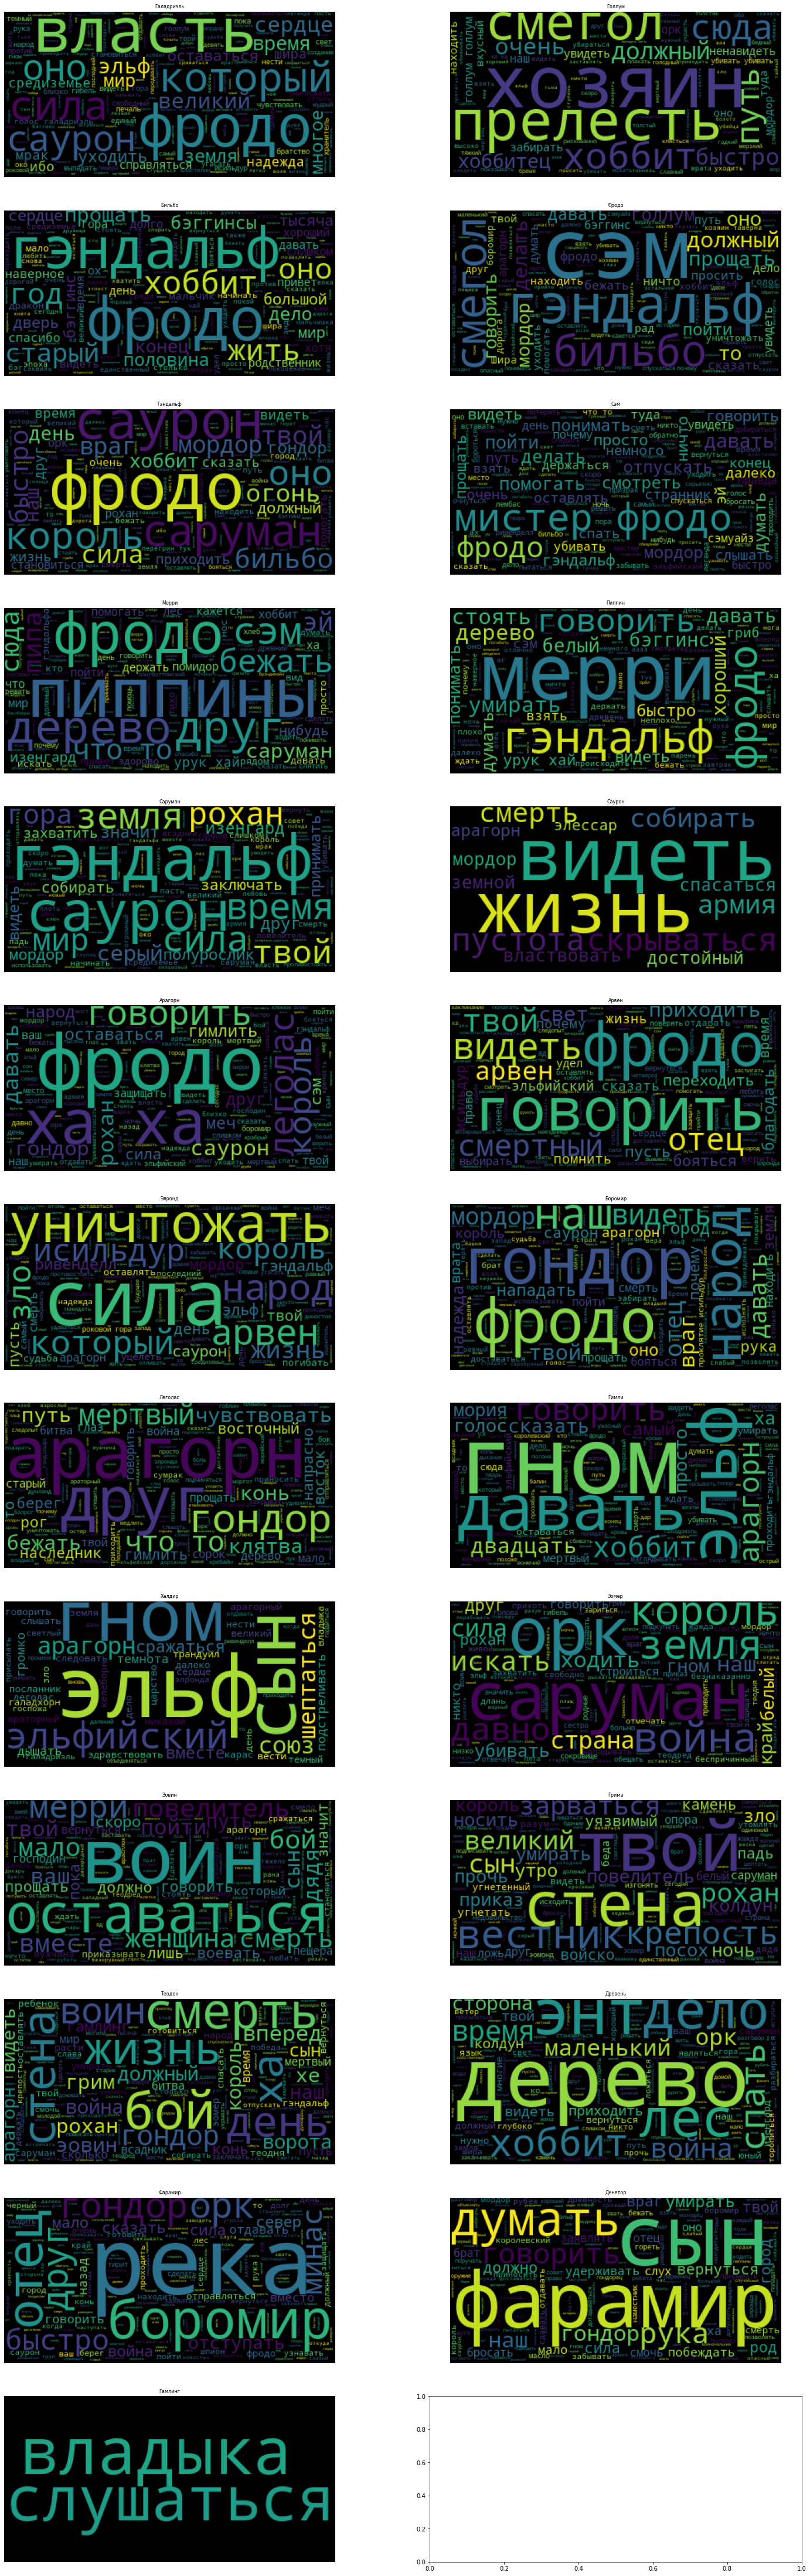

In [325]:
plot_wordclouds(df_lotr_replics);